## Importing necessary libs

In [55]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import defaultdict

## Preparing features and labels from pruned dataframe

In [80]:
df = pd.read_csv("fe_data.csv")
df = df.drop("userID_anonymized", 1) # since it's not a feature and we need number indexes in CV

## Setting categorical columns
df["model"] = df["model"].astype("category")
df["operating_system"] = df["operating_system"].astype("category")


Xs = df.copy()

categorical_features = ["model","operating_system"]

for feature in categorical_features:
    Xs[feature] = LabelEncoder().fit_transform(df[feature])

In [81]:
Xs.head()

,mean_revenue_banner_impression,mean_revenue_interstitial_impression,mean_revenue_level_event,mean_revenue_rewarded_impression,std_revenue_banner_impression,std_revenue_interstitial_impression,std_revenue_level_event,std_revenue_rewarded_impression,total_count_banner_impression,total_count_interstitial_impression,...,last_time_banner_impression,last_time_interstitial_impression,last_time_level_event,last_time_rewarded_impression,model,operating_system,mean_wifi_state,last_session_no,last_level,totalrevenue
0,0.000400,0.030000,0.0,0.00,0.000000,0.000000,0.0,0.0,6,1,...,13.0,2.0,14.0,0.0,70,48,1.000000,3,65,0.032400
1,0.000375,0.030000,0.0,0.00,0.000318,0.000000,0.0,0.0,2,1,...,0.0,0.0,0.0,0.0,53,50,1.000000,1,4,0.030750
2,0.000669,0.027517,0.0,0.04,0.000962,0.005541,0.0,0.0,118,30,...,4078.0,4076.0,4078.0,1621.0,56,49,0.814159,8,1004,1.211006
3,0.000416,0.022920,0.0,0.04,0.000184,0.005129,0.0,0.0,82,25,...,5137.0,5136.0,5137.0,763.0,74,46,1.000000,5,1003,0.881707
4,0.000537,0.030000,0.0,0.00,0.000096,0.003536,0.0,0.0,16,5,...,2368.0,2035.0,2369.0,0.0,45,50,1.000000,4,67,0.184700


## Defining Silhuette Analysis

In [66]:
def silhuette(X):
    for i, k in enumerate([2, 3, 4, 5, 6, 7, 8]):
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(9, 3.5)

        # Run the Kmeans algorithm
        km = KMeans(n_clusters=k)
        labels = km.fit_predict(X)
        centroids = km.cluster_centers_

        # Get silhouette samples
        silhouette_vals = silhouette_samples(X, labels)

        # Silhouette plot
        y_ticks = []
        y_lower, y_upper = 0, 0
        for i, cluster in enumerate(np.unique(labels)):
            cluster_silhouette_vals = silhouette_vals[labels == cluster]
            cluster_silhouette_vals.sort()
            y_upper += len(cluster_silhouette_vals)
            ax.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
            ax.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
            y_lower += len(cluster_silhouette_vals)

        # Get the average silhouette score and plot it
        avg_score = np.mean(silhouette_vals)
        ax.axvline(avg_score, linestyle='--', linewidth=2, color='green')
        ax.set_yticks([])
        ax.set_xlim([-0.1, 1])
        ax.set_xlabel('Silhouette coefficient values')
        ax.set_ylabel('Cluster labels')
        ax.set_title('Silhouette plot for the various clusters', y=1.02);

        plt.tight_layout()
        plt.suptitle(f'Silhouette analysis using k = {k}',
                     fontsize=16, fontweight='semibold', y=1.05);

### Silhuette Results for raw pruned data

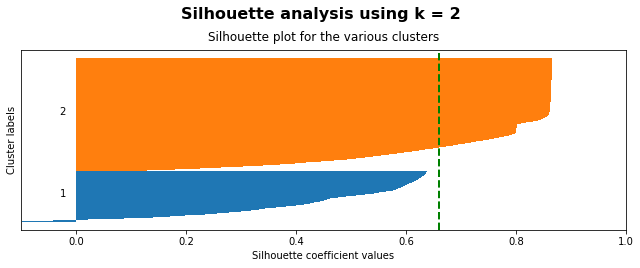

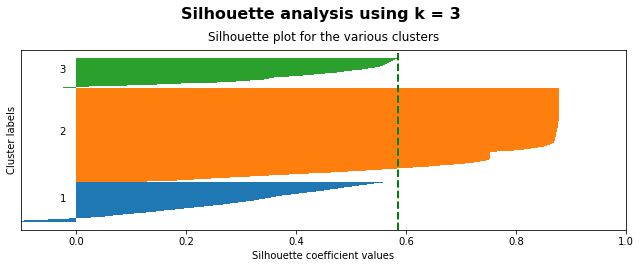

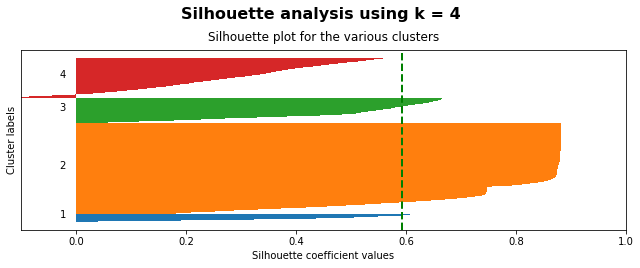

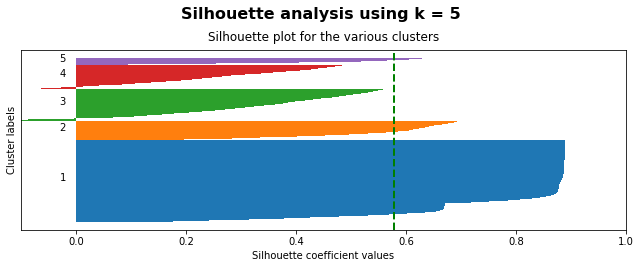

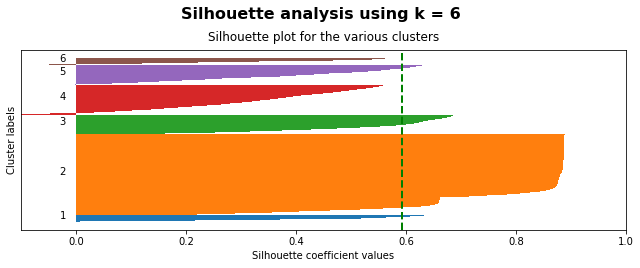

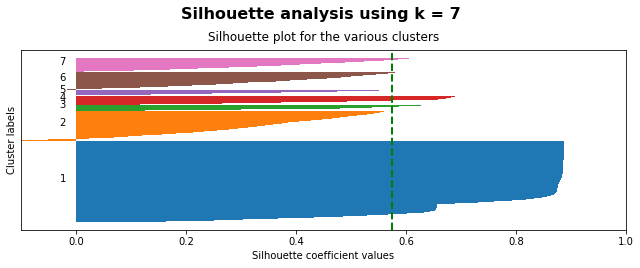

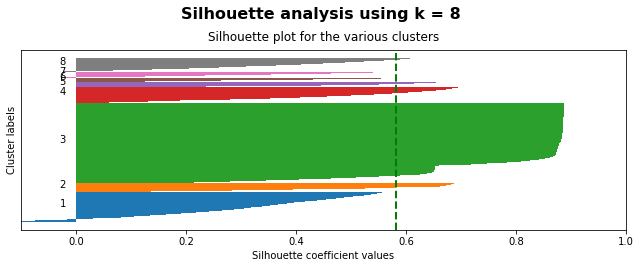

In [67]:
silhuette(Xs)

### Dimension Reduction and Standardization for better results

In [68]:
ipca = PCA(n_components=3)
std_scaler = StandardScaler()

Xs_std = std_scaler.fit_transform(Xs)
Xs_PCA = ipca.fit_transform(Xs_std)
Xs_PCA

array([[-2.2455496 , -0.50936729, -0.69037695],
       [-2.48088709, -0.45392164, -0.23075297],
       [ 5.03624309,  0.50716449,  1.41431307],
       ...,
       [-2.13616208, -0.49631116, -0.37735379],
       [-2.33810374, -0.45454736,  0.75458145],
       [-0.44027907,  0.77128171, -0.95031863]])

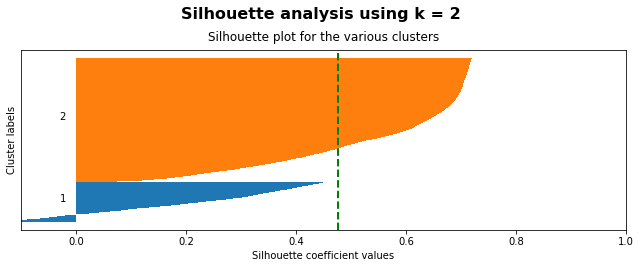

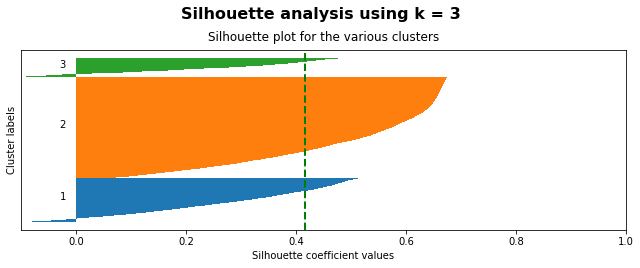

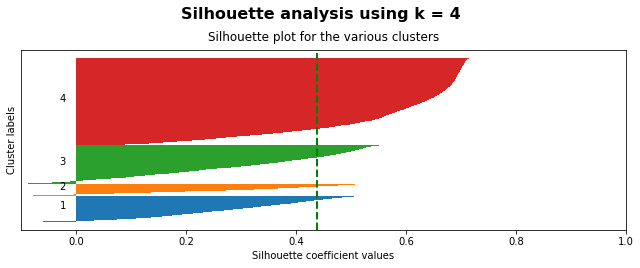

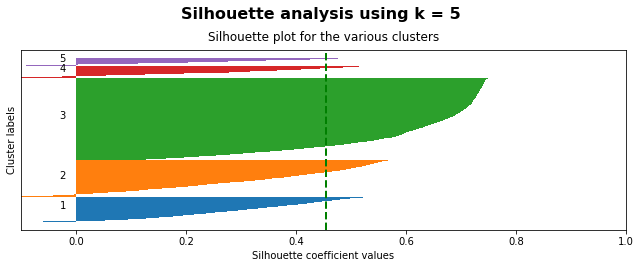

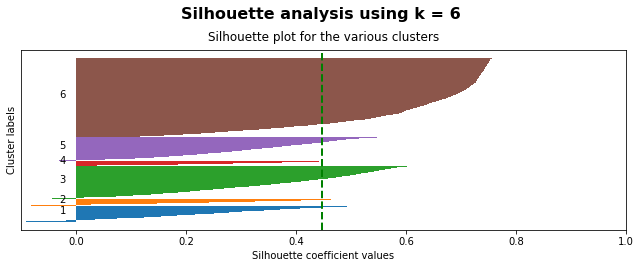

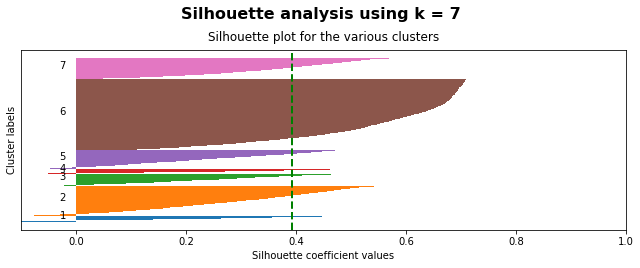

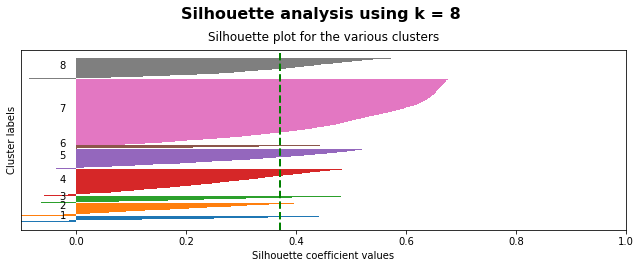

In [69]:
silhuette(Xs_PCA)

## Interpreting Results

In [121]:
km = KMeans(n_clusters=3)
labels = km.fit_predict(Xs_PCA)

In [122]:
df["cluster_id"] = labels

In [123]:
df.head()

,mean_revenue_banner_impression,mean_revenue_interstitial_impression,mean_revenue_level_event,mean_revenue_rewarded_impression,std_revenue_banner_impression,std_revenue_interstitial_impression,std_revenue_level_event,std_revenue_rewarded_impression,total_count_banner_impression,total_count_interstitial_impression,...,last_time_interstitial_impression,last_time_level_event,last_time_rewarded_impression,model,operating_system,mean_wifi_state,last_session_no,last_level,totalrevenue,cluster_id
0,0.000400,0.030000,0.0,0.00,0.000000,0.000000,0.0,0.0,6,1,...,2.0,14.0,0.0,"iPhone8,2",iOS 14.0.1,1.000000,3,65,0.032400,0
1,0.000375,0.030000,0.0,0.00,0.000318,0.000000,0.0,0.0,2,1,...,0.0,0.0,0.0,"iPhone12,1",iOS 14.2,1.000000,1,4,0.030750,0
2,0.000669,0.027517,0.0,0.04,0.000962,0.005541,0.0,0.0,118,30,...,4076.0,4078.0,1621.0,"iPhone12,8",iOS 14.1,0.814159,8,1004,1.211006,1
3,0.000416,0.022920,0.0,0.04,0.000184,0.005129,0.0,0.0,82,25,...,5136.0,5137.0,763.0,"iPhone9,3",iOS 13.7,1.000000,5,1003,0.881707,1
4,0.000537,0.030000,0.0,0.00,0.000096,0.003536,0.0,0.0,16,5,...,2035.0,2369.0,0.0,"iPhone10,2",iOS 14.2,1.000000,4,67,0.184700,0


In [124]:
df[df["cluster_id"]==0].mean()

mean_revenue_banner_impression            0.000538
mean_revenue_interstitial_impression      0.026866
mean_revenue_level_event                  0.000000
mean_revenue_rewarded_impression          0.006196
std_revenue_banner_impression             0.000188
std_revenue_interstitial_impression       0.003462
std_revenue_level_event                   0.000000
std_revenue_rewarded_impression           0.000177
total_count_banner_impression            17.110574
total_count_interstitial_impression       4.784651
total_count_level_event                  17.548231
total_count_rewarded_impression           0.193891
last_time_banner_impression             422.371738
last_time_interstitial_impression       247.264063
last_time_level_event                   426.120820
last_time_rewarded_impression            31.518268
mean_wifi_state                           0.790943
last_session_no                           1.862556
last_level                              190.845931
totalrevenue                   

In [125]:
df[df["cluster_id"]==1].mean()

mean_revenue_banner_impression             0.000411
mean_revenue_interstitial_impression       0.022100
mean_revenue_level_event                   0.000000
mean_revenue_rewarded_impression           0.032859
std_revenue_banner_impression              0.000252
std_revenue_interstitial_impression        0.006976
std_revenue_level_event                    0.000000
std_revenue_rewarded_impression            0.007394
total_count_banner_impression            124.338870
total_count_interstitial_impression       35.415282
total_count_level_event                   95.688815
total_count_rewarded_impression            3.233666
last_time_banner_impression             3333.734219
last_time_interstitial_impression       3084.500554
last_time_level_event                   3322.251384
last_time_rewarded_impression           1756.807309
mean_wifi_state                            0.779453
last_session_no                            7.457364
last_level                               909.490587
totalrevenue

In [126]:
df[df["cluster_id"]==2].mean()

mean_revenue_banner_impression             0.000531
mean_revenue_interstitial_impression       0.028099
mean_revenue_level_event                   0.000000
mean_revenue_rewarded_impression           0.008672
std_revenue_banner_impression              0.000318
std_revenue_interstitial_impression        0.006661
std_revenue_level_event                    0.000000
std_revenue_rewarded_impression            0.000040
total_count_banner_impression             46.662372
total_count_interstitial_impression       13.159485
total_count_level_event                   40.241226
total_count_rewarded_impression            0.265660
last_time_banner_impression             3563.035096
last_time_interstitial_impression       3086.371390
last_time_level_event                   3559.883163
last_time_rewarded_impression            230.385606
mean_wifi_state                            0.744392
last_session_no                            5.124389
last_level                               247.210573
totalrevenue

### Getting each cluster's dominant features

In [128]:
res_dict = defaultdict(lambda:defaultdict(float))

for col in df.columns:
    if df[col].dtype == "float64":
        max_id = 0
        maxval = 0
        for i in range(4):
            meanval = df[col][df["cluster_id"]==i].mean()
            if meanval > maxval:
                maxval = meanval
                max_id = i
        res_dict[max_id][col] = maxval

These are each cluster's dominant features:

In [129]:
dict(res_dict)

{0: defaultdict(float,
             {'mean_revenue_banner_impression': 0.000537631210412723,
              'mean_revenue_level_event': 0,
              'std_revenue_level_event': 0,
              'mean_wifi_state': 0.7909433379146888}),
 2: defaultdict(float,
             {'mean_revenue_interstitial_impression': 0.028099123729425853,
              'std_revenue_banner_impression': 0.0003181792109062346,
              'last_time_banner_impression': 3563.0350955131053,
              'last_time_interstitial_impression': 3086.371390493114,
              'last_time_level_event': 3559.8831630386494}),
 1: defaultdict(float,
             {'mean_revenue_rewarded_impression': 0.03285871065058586,
              'std_revenue_interstitial_impression': 0.006975921240415205,
              'std_revenue_rewarded_impression': 0.007394042973131826,
              'last_time_rewarded_impression': 1756.8073089700997,
              'totalrevenue': 1.036473591374308})}